In [1]:
import kagglehub

path = kagglehub.dataset_download("alanvourch/tmdb-movies-daily-updates")

print("Path to dataset files:", path)

C:\Users\Alex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 249M/249M [00:10<00:00, 25.7MB/s] 

Extracting files...


Path to dataset files: C:\Users\Alex\.cache\kagglehub\datasets\alanvourch\tmdb-movies-daily-updates\versions\297


In [63]:
""" First Cleanup: drop unnecessary columns and rows with NaN values """

import pandas as pd

# Load CSV from './TMDB_all_movies.csv'
df = pd.read_csv(f"{path}/TMDB_all_movies.csv")

# Leave only the columns ['id', 'title', 'vote_average', 'status', 'release_date', 'budget', 'revenue', 'popularity', 'genres', 'cast', 'director', 'production_companies']
df = df[['id', 'title', 'vote_average', 'status', 'release_date', 'budget', 'revenue', 'popularity', 'genres', 'cast', 'director', 'production_companies']]

# Drop rows with NaN values
df = df.dropna()

# Save the result to './TMDB_all_movies_cleaned.csv'
df.to_csv('./TMDB_all_movies_cleaned.csv', index=False)

            id            title  vote_average    status release_date  \
56665    80035        The Watch           5.6  Released   2012-07-26   
408276  581389   Space Sweepers           7.1  Released   2021-02-05   
33573    49797  I Saw the Devil           7.8  Released   2010-08-12   
9000     15080   Only Yesterday           7.4  Released   1991-07-20   
3308      5924         Papillon           7.8  Released   1973-12-16   

            budget     revenue  popularity                           genres  \
56665   68000000.0  68267862.0      29.998  Comedy, Action, Science Fiction   
408276  21000000.0     24571.0      29.992  Drama, Fantasy, Science Fiction   
33573    6000000.0  12966357.0      29.992                 Thriller, Horror   
9000           0.0    473110.0      29.989        Animation, Drama, Romance   
3308    12000000.0  53267000.0      29.988                     Crime, Drama   

                                                     cast  \
56665   Kate Kneeland, Erinn Ha

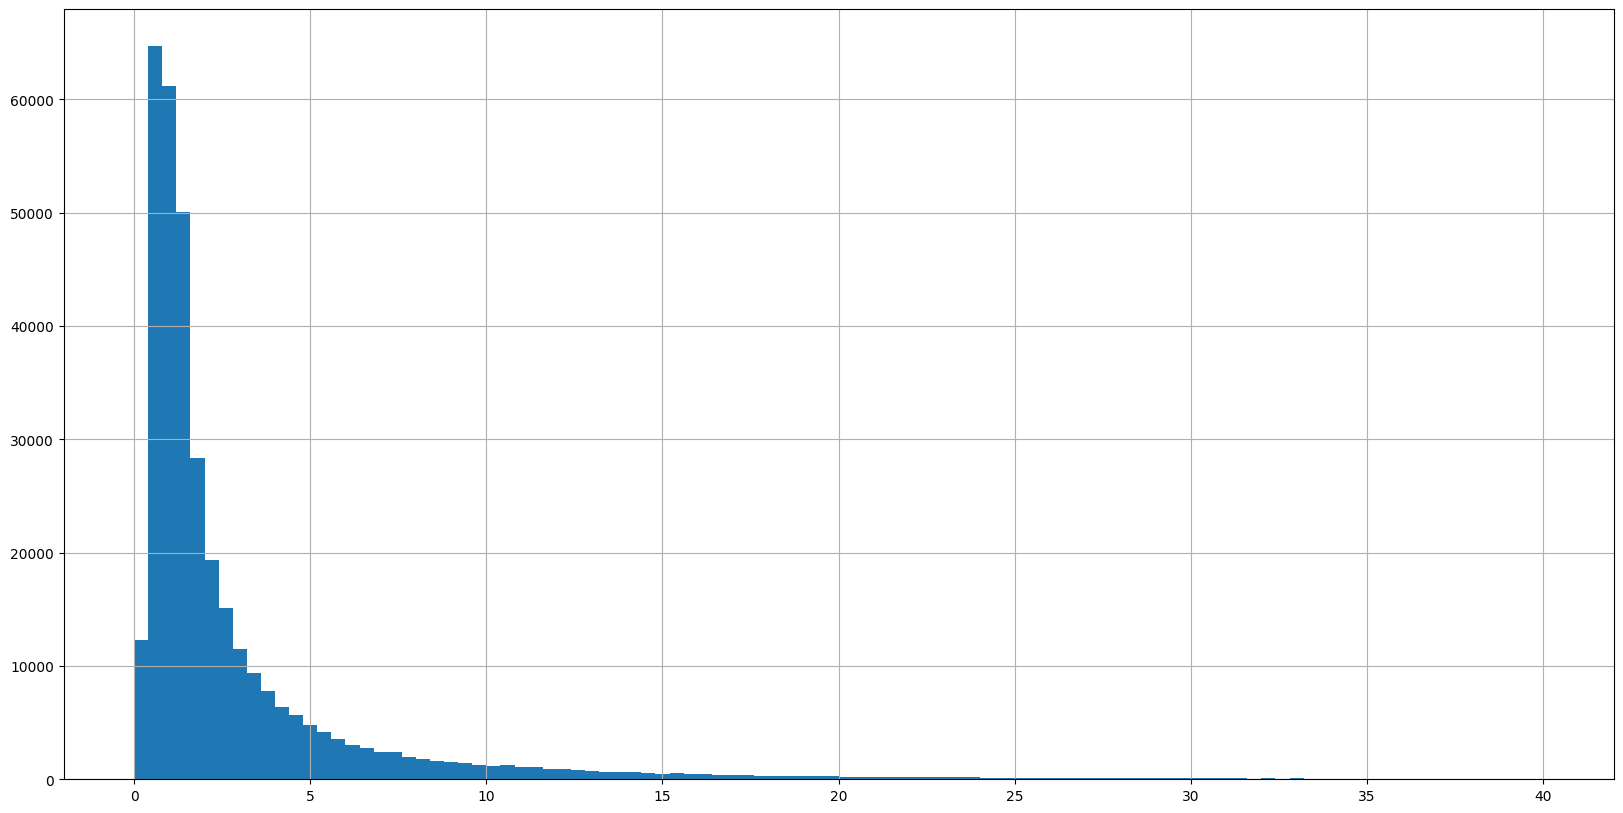

In [ ]:
""" Second Cleanup: remove movies with a popularity below 20, a budget below 1000, released before 1970, or with a status different from 'Released' """

# Show some examples of movies with a popularity between 0 and 5, sorted by popularity
print(df[(df['popularity'] >= 25) & (df['popularity'] < 30)].sort_values(by='popularity', ascending=False).head())

# Make an histogram of the 'popularity' column, with 100 bins, with an interval of 5 ([0, 5[, [5, 10[, [10, 15[, etc.)])
df['popularity'].hist(bins=100, range=(0, 40), figsize=(20, 10))

# Remove movies with a popularity below 20
df = df[df['popularity'] >= 5]

# Remove movies with a budget below 1000
df = df[df['budget'] > 1000]

# Remove movies released before 1970
df = df[df['release_date'] >= '1970-01-01']

# Only keep movies with a status of 'Released'
df = df[df['status'] == 'Released']

# Save the result to './TMDB_all_movies_cleaned_2.csv'
df.to_csv('./TMDB_all_movies_cleaned_2.csv', index=False)


In [65]:
""" Final Processing: add columns 'release_year' and 'roi' to the dataset, and save it to 'movies.csv' """

# Count the number of movies before processing
print(df.shape[0])

df['release_year'] = pd.to_datetime(df['release_date']).dt.year

df['roi'] = (df['revenue'] - df['budget']) / df['budget'] * 100

# Remove movies with a roi equal to or below -100
df = df[df['roi'] > -100]

# Count the number of movies
print(df.shape[0])

# Movies data
movies = df[['id', 'title', 'vote_average', 'release_date', 'release_year', 'budget', 'revenue', 'roi', 'cast', 'popularity', 'genres', 'production_companies', 'director']]
movies.to_csv('./movies.csv', index=False)

12199
8693


In [66]:
def genre_average_rating(data, top_genres_column):
    def calc(row):
        top_genres = row[top_genres_column]
        ratings = {}
        for genre in top_genres:
            ratings[genre] = data.loc[data['genres'].apply(lambda g: genre in g), 'vote_average'].mean()
        return ratings
    return calc

In [67]:
# Actors data
actors_data = df[['id', 'cast', 'vote_average', 'budget', 'revenue', 'genres', 'popularity']]
actors_data['cast'] = actors_data['cast'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
actors_data['genres'] = actors_data['genres'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
actors = actors_data.explode('cast')  # Split the list of actors into rows
actors = actors.rename(columns={'id': 'movie_id', 'cast': 'actor'})

actor_stats = (
    actors.groupby('actor', as_index=False)
    .agg(
        average_budget=('budget', 'mean'),
        average_revenue=('revenue', 'mean'),
        movies_count=('movie_id', 'count'),
        top_genres=('genres', lambda x: pd.Series(x.explode().unique()).value_counts().head(5).index.tolist()),
        popularity_over_time=('popularity', list),
    )
)

actor_stats.to_csv('./actors.csv', index=False)

C:\Users\Alex\AppData\Local\Temp\ipykernel_28920\49760351.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actors_data['cast'] = actors_data['cast'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
C:\Users\Alex\AppData\Local\Temp\ipykernel_28920\49760351.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  actors_data['genres'] = actors_data['genres'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)


KeyboardInterrupt: 

In [ ]:
movies['cast'] = movies['cast'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
movies['genres'] = movies['genres'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

movies_exploded = movies.explode('cast').explode('genres')
movies_exploded = movies_exploded.rename(columns={'cast': 'actor', 'genres': 'genre'})

average_genre_rating = (
    movies_exploded.groupby(['actor', 'genre'])
    .agg(average_rating=('vote_average', 'mean'))
    .reset_index()
)

average_genre_rating['average_rating'] = average_genre_rating['average_rating'].round(2)

actor_genre_ratings = (
    average_genre_rating.groupby('actor')
    .apply(lambda x: [{'genre': row['genre'], 'average_rating': row['average_rating']} for _, row in x.iterrows()])
    .reset_index(name='genre_ratings')
)

actor_stats.to_csv('./actors.csv', index=False)
movies_with_actor_ratings = pd.merge(
    movies_exploded[['actor']].drop_duplicates(), 
    actor_genre_ratings, 
    on='actor', 
    how='left'
)

movies_with_actor_ratings.to_csv('./actors_with_genre_ratings.csv', index=False)

C:\Users\Alex\AppData\Local\Temp\ipykernel_28920\1490935304.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['cast'] = movies['cast'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
C:\Users\Alex\AppData\Local\Temp\ipykernel_28920\1490935304.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['genres'] = movies['genres'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
C:\Users\Alex\AppData\Local\Temp\ipykernel_28920\1490935304.py:17: DeprecationWarning: DataFrameGrou

In [ ]:
# Directors data
directors_data = df[['id', 'director', 'vote_average', 'budget', 'revenue', 'genres', 'popularity']]
directors_data['director'] = directors_data['director'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
directors_data['genres'] = directors_data['genres'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
directors = directors_data.explode('director')  # Explode to get one director per row
directors = directors.rename(columns={'id': 'movie_id', 'director': 'director_name'})

director_stats = (
    directors.groupby('director_name')
    .agg(
        average_budget=('budget', 'mean'),
        average_revenue=('revenue', 'mean'),
        movies_count=('movie_id', 'count'),
        top_genres=('genres', lambda x: pd.Series(x.explode().unique()).value_counts().head(5).index.tolist()),
        popularity_over_time=('popularity', list)
    )
    .reset_index()
)

director_stats.to_csv('./directors.csv', index=False)


C:\Users\Alex\AppData\Local\Temp\ipykernel_28920\767172204.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  directors_data['director'] = directors_data['director'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
C:\Users\Alex\AppData\Local\Temp\ipykernel_28920\767172204.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  directors_data['genres'] = directors_data['genres'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)


In [ ]:
movies['director'] = movies['director'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
movies['genres'] = movies['genres'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)

movies_exploded = movies.explode('director').explode('genres')
movies_exploded = movies_exploded.rename(columns={'director': 'director_name', 'genres': 'genre'})

average_genre_rating = (
    movies_exploded.groupby(['director_name', 'genre'])
    .agg(average_rating=('vote_average', 'mean'))
    .reset_index()
)

average_genre_rating['average_rating'] = average_genre_rating['average_rating'].round(2)

director_genre_ratings = (
    average_genre_rating.groupby('director_name')
    .apply(lambda x: [{'genre': row['genre'], 'average_rating': row['average_rating']} for _, row in x.iterrows()])
    .reset_index(name='genre_ratings')
)

movies_with_director_ratings = pd.merge(
    movies_exploded[['director_name']].drop_duplicates(), 
    director_genre_ratings, 
    on='director_name', 
    how='left'
)

movies_with_director_ratings.to_csv('./directors_with_genre_ratings.csv', index=False)

C:\Users\Alex\AppData\Local\Temp\ipykernel_28920\1393155559.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['director'] = movies['director'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
C:\Users\Alex\AppData\Local\Temp\ipykernel_28920\1393155559.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['genres'] = movies['genres'].apply(lambda x: x.split(', ') if isinstance(x, str) else x)
C:\Users\Alex\AppData\Local\Temp\ipykernel_28920\1393155559.py:17: DeprecationWarning: DataF